# Anomaly Detection

In [31]:
## Notebook config

import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [32]:
# Notebook imports
import ast
import os
import pickle
import collections 
import csv


from Bio import Entrez, SeqIO
from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import umap

In [ ]:
DATASET_DIR = './dataset_v1/'
PROJECTION_NAME_PREFIX = 'anomaly_projection_'
RANDOM_SEED = 42

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')


In [33]:
# GDS utils
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)

def get_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    projection = gds.graph.project(
        graph_name=projection_name,
        node_spec=[
            'Genome',
            'FuncDomain',
            'FuncDomainSet',
            'FuncDomainClan',
        ],
        relationship_spec={
            'HasReg': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'HasMember': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'hasNextDomainSet': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'hasClanEntry': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} } },
            'homologousTo': {'orientation': 'NATURAL', 'properties': {'identity': {'defaultValue': 0} }},
            'hasClanHomology': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1}, 'linkscore': {'defaultValue': 1}}},
        },
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


In [34]:
# Create GDS projection

version = 1
projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name)
target_property = 'fastrp' 
node_label = 'Genome'
class_label = 'phylum' 
print(projection)

GraphCreateResult(graph=Graph({'graphName': 'anomaly_projection_1', 'nodeCount': 33453, 'relationshipCount': 1345820, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'HasReg': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}}, 'type': 'HasReg'}, 'hasClanHomology': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}, 'linkscore': {'aggregation': 'DEFAULT', 'property': 'linkscore', 'defaultValue': 1}}, 'type': 'hasClanHomology'}, 'HasMember': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}}, 'type': 'HasMember'}, 'homologousTo': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': F

In [35]:
gds.fastRP.mutate(
    G=gds.graph.get(projection_name),
    mutateProperty='fastrp',
    randomSeed=RANDOM_SEED,
    relationshipWeightProperty='identity',
    nodeLabels=["*"],
    relationshipTypes=[
        # "*",
        'HasReg',
        'HasMember',
        'hasNextDomainSet',
        'hasClanEntry',
        'homologousTo',
        'hasClanHomology',
    ],
    embeddingDimension=128,
    normalizationStrength=-0.5,
    # nodeSelfInfluence=2,
)

FastRP: 100%|██████████| 100.0/100 [00:02<00:00, 42.75%/s]


nodePropertiesWritten                                                33453
mutateMillis                                                             2
nodeCount                                                            33453
preProcessingMillis                                                      1
computeMillis                                                         2744
configuration            {'randomSeed': 42, 'mutateProperty': 'fastrp',...
Name: 0, dtype: object

In [36]:
def export_nodes_from_projection(property):
    exported_projection = gds.graph.nodeProperties.stream(
        get_projection(gds, get_projection_name()),
        node_properties=[property],
        separate_property_columns=True,
        db_node_properties=['accession', 'name', 'annotation', 'source', 'taxonomy'],
        listNodeLabels=True,
    )
    exported_projection['nodeLabels'] = exported_projection['nodeLabels'].apply(lambda x: x[0])
    return exported_projection


exported_projection = export_nodes_from_projection(target_property)

In [37]:
# Enrich Genomes with taxonomic labels from ICTV

def get_taxonomy_by_idx(tax_str, idx):
    try:
        return tax_str.split(';')[idx].strip()
    except:
        return None

def enrich_data_with_tax_labels(df, rank):
    rank_getters = {
        'clade': 0,
        'kingdom': 2,
        'phylum': 4,
        'class': 6,
        'order': 8,
        'family': 10,
        'genus': 12,
        'species': 14,
    }
    df[rank] = None
    
    df.loc[df['nodeLabels'] == 'Genome', rank] = df.loc[
        df['nodeLabels'] == 'Genome', 'taxonomy'].apply(get_taxonomy_by_idx, args=[rank_getters[rank]])
    return df


for rank in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
    exported_projection = enrich_data_with_tax_labels(exported_projection, rank)


In [ ]:
def get_knn(source_node_ids, k = 3):
    return gds.knn.filtered.stream(
        G=gds.graph.get(projection_name),
        relationshipTypes=["*"],
        # randomSeed=RANDOM_SEED,
        topK=k,
        sourceNodeFilter=source_node_ids,
        targetNodeFilter="Genome",
        nodeProperties=[target_property],
        similarityCutoff=0.5,
        logProgress=False
    )

In [ ]:
filename = DATASET_DIR + 'anomaly_detection.csv'
existing_df = pd.read_csv(filename)
last_processed = existing_df.iloc[-1]

all_genomes = exported_projection[exported_projection['nodeLabels'] == 'Genome']
# reset index
all_genomes = all_genomes.reset_index(drop=True)

print(len(all_genomes))
print(all_genomes[all_genomes['nodeId'] == last_processed['nodeId']].index[0] + 1)

In [ ]:
all_genomes = exported_projection[exported_projection['nodeLabels'] == 'Genome']
all_genomes = all_genomes.reset_index(drop=True)

filename = DATASET_DIR + 'anomaly_detection.csv'
headers = ['nodeId', 'accession', 'targetValue', 'KNN_nodeIds', 'KNN_targetValues']
if os.path.exists(filename):
    existing_df = pd.read_csv(filename)
    last_processed = existing_df.iloc[-1]
    start_index = all_genomes[all_genomes['nodeId'] == last_processed['nodeId']].index[0] + 1
else:
    start_index = 0
    with open(filename, 'w', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(headers)

with open(filename, 'a', newline="") as f:
    writer = csv.writer(f)

    for index, genome in all_genomes.iloc[start_index:].iterrows():
        node_id = genome['nodeId']
        # print(node_id)
        if index % 10 == 0:
            print(f'Processing {index}/{len(all_genomes)}') 
            
        order = genome['order']
        accession = genome['accession']

        knn = get_knn([node_id])
        if knn.empty:
            print(f'No KNN for {genome}')
            writer.writerow([node_id, accession, order, [], None])
            continue

        merged = pd.merge(knn, all_genomes, left_on='node2', right_on='nodeId', how='left')
        matched_orders = merged[merged['order'] == order]
        if len(matched_orders) < 1:
            print(f'No matched orders for {genome}')
            writer.writerow([node_id, accession, order, merged['node2'].tolist(), merged['order'].tolist()])


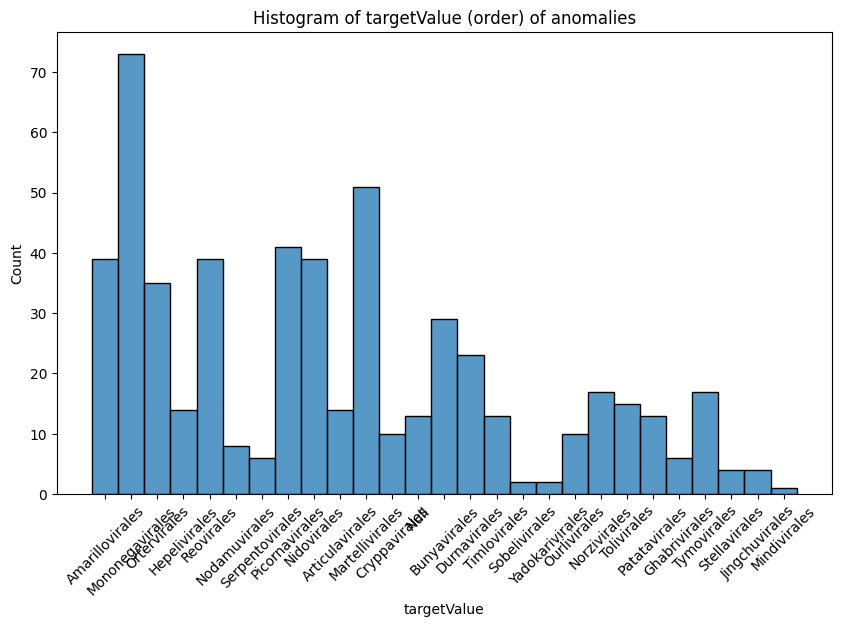

In [60]:
anomalous = pd.read_csv('dataset_v1/' + 'anomaly_detection.csv')

# plot histogram of targetValue (order) of anomalies
plt.figure(figsize=(10, 6))
sns.histplot(anomalous['targetValue'], bins=50)
plt.title('Histogram of targetValue (order) of anomalies')
plt.xticks(rotation=45)
plt.show()

In [61]:
predictions = pd.read_csv('dataset_v1/' + 'pred_genome_nodes.csv')

# find overlap
anomalous_nodes = anomalous['accession'].tolist()
incorrect_nodes = predictions.loc[
    predictions['correct'] == False,
    'appId'
].tolist()
overlap = set(anomalous_nodes).intersection(incorrect_nodes)

print(len(anomalous_nodes))
print(len(incorrect_nodes))
print(len(overlap))
print(overlap)

538
17
7
{'AF020541', 'OK040226', 'DQ143874', 'KT727026', 'EF681765', 'KU052531', 'KX812816'}


In [38]:
all_embeddings = pd.DataFrame(exported_projection[target_property].to_list())
reducer = umap.UMAP()
umap_emb = reducer.fit_transform(all_embeddings)

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


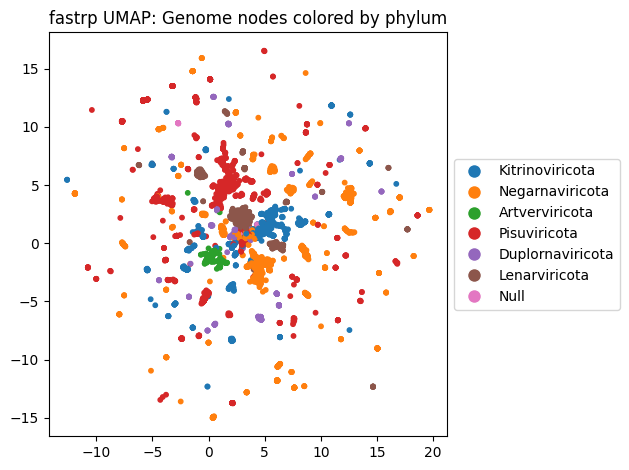

In [44]:
# Plot UMAP of target node label, colored by top k target rank

unique_rank = exported_projection[class_label].unique()
unique_rank = unique_rank[unique_rank != '']
unique_rank = unique_rank[~pd.isnull(unique_rank)]
rank_palette = sns.color_palette("tab10", len(unique_rank))
rank_palette = {genus: color for genus, color in zip(unique_rank, rank_palette)}
exported_projection['label_color'] = exported_projection[class_label].map(rank_palette)


plt.scatter(
    umap_emb[exported_projection.nodeLabels == node_label, 0],
    umap_emb[exported_projection.nodeLabels == node_label, 1],
    c=exported_projection.loc[exported_projection.nodeLabels == node_label, 'label_color'],
    s=10
)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in rank_palette.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{target_property} UMAP: {node_label} nodes colored by {class_label}')
fig = plt.gcf()
plt.tight_layout()

plt.show()


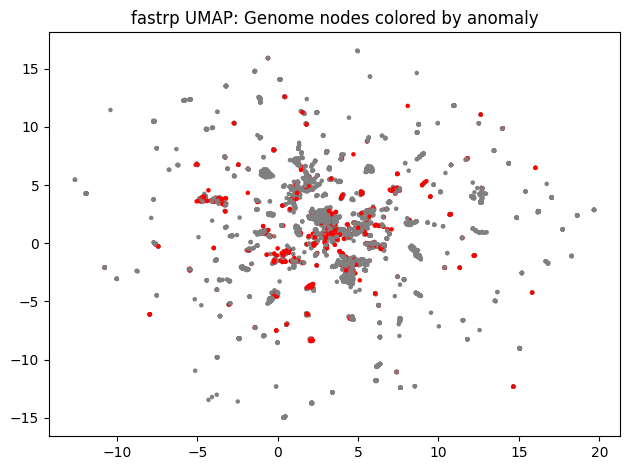

In [57]:
# plot umap, color anomalies

anomalous = pd.read_csv('dataset_v1/' + 'anomaly_detection.csv')
anomalous_nodes = anomalous['accession'].tolist()
anomalous_nodes = exported_projection[exported_projection['accession'].isin(anomalous_nodes)]
anomalous_nodes = anomalous_nodes[anomalous_nodes['nodeLabels'] == node_label]


exported_projection['label_color'] = 'grey'
exported_projection.loc[exported_projection['accession'].isin(anomalous['accession']), 'label_color'] = 'red'
plt.scatter(
    umap_emb[exported_projection.nodeLabels == node_label, 0],
    umap_emb[exported_projection.nodeLabels == node_label, 1],
    c=exported_projection.loc[exported_projection.nodeLabels == node_label, 'label_color'],
    s=5
)
plt.title(f'{target_property} UMAP: {node_label} nodes colored by anomaly')
fig = plt.gcf()
plt.tight_layout()

plt.show()

In [53]:
from pygod.detector import DOMINANT
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData

seed_everything(RANDOM_SEED)

detector = DOMINANT(hid_dim=64, num_layers=4, epoch=100)


label_color
(1.0, 0.4980392156862745, 0.054901960784313725)                   2434
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)     1556
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)    1036
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)      977
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)        291
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)     138
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)        21
Name: count, dtype: int64


In [78]:
data = HeteroData()

# add nodes
data['Genome'] = torch.tensor(exported_projection[target_property].to_list(), dtype=torch.float)
data['Genome'].y = torch.tensor([1 if accession in anomalous['accession'].tolist() else 0 for accession in exported_projection['accession']], dtype=torch.float)

# add edges

# convert to homogenous graph 
# data = data.to_homogeneous()


KeyError: "Tried to collect 'num_nodes' but did not find any occurrences of it in any node and/or edge type"